# Using Machine Learning to help reduce employee turnover




## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

In [96]:
# importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV



### 🥕EDA


In [2]:
# reading the data
df = pd.read_csv('./data/employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [3]:
df.tail()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
9535,operations,0,0.610988,4,medium,8.0,0.543641,0,188.155738,yes
9536,logistics,0,0.746887,3,medium,8.0,0.549048,0,188.176164,yes
9537,operations,0,0.557980,3,low,7.0,0.705425,0,186.531008,yes
9538,IT,0,0.584446,4,medium,8.0,0.607287,1,187.641370,yes
9539,finance,0,0.626373,3,low,7.0,0.706455,1,185.920934,yes


In [4]:
df.shape

(9540, 10)

In [5]:
df.describe()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


In [6]:
df.columns

Index(['department', 'promoted', 'review', 'projects', 'salary', 'tenure',
       'satisfaction', 'bonus', 'avg_hrs_month', 'left'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


In [97]:
df.isnull().sum()

department       0
promoted         0
review           0
projects         0
salary           0
tenure           0
satisfaction     0
bonus            0
avg_hrs_month    0
left             0
dtype: int64

In [9]:
left = df.groupby('left')
left.mean()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
left,,,,,,,
no,0.034340,0.635164,3.279455,6.546625,0.505634,0.215068,184.637605
yes,0.020474,0.692262,3.263649,6.579382,0.502244,0.204741,184.719730


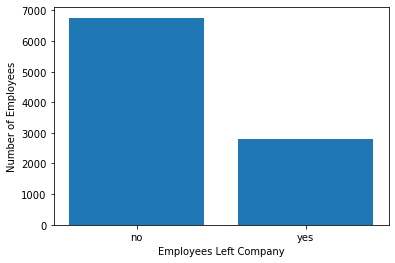

In [10]:
left_count=df.groupby('left').count()
plt.bar(left_count.index.values, left_count['satisfaction'])
plt.xlabel('Employees Left Company')
plt.ylabel('Number of Employees')
plt.show()

In [11]:
df.left.value_counts()

no     6756
yes    2784
Name: left, dtype: int64

In [72]:
2784/len(df['left'])

0.2918238993710692

In [13]:
# 29% of employees have left the company, which is quite a high turnover rate

In [14]:
# looking at correlations
cormat = df.corr()
round(cormat,2)

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
promoted,1.00,0.00,0.01,0.00,-0.01,0.0,-0.00
review,0.00,1.00,0.00,-0.18,-0.35,-0.0,-0.20
projects,0.01,0.00,1.00,0.02,0.00,0.0,0.02
tenure,0.00,-0.18,0.02,1.00,-0.15,-0.0,0.98
satisfaction,-0.01,-0.35,0.00,-0.15,1.00,0.0,-0.14
bonus,0.00,-0.00,0.00,-0.00,0.00,1.0,-0.00
avg_hrs_month,-0.00,-0.20,0.02,0.98,-0.14,-0.0,1.00


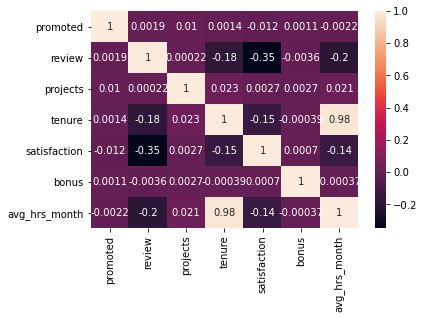

In [15]:
sns.heatmap(cormat, annot=True);

Negative relationship between review and satsifaction-
Shown with regression plot

<AxesSubplot:xlabel='review', ylabel='satisfaction'>

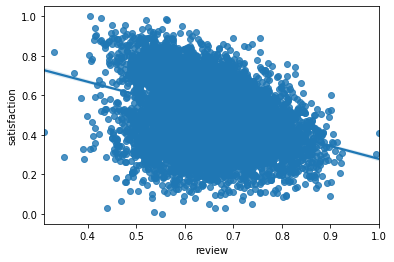

In [16]:
sns.regplot(data=df,x='review',y='satisfaction')

Text(0, 0.5, 'Frequency')

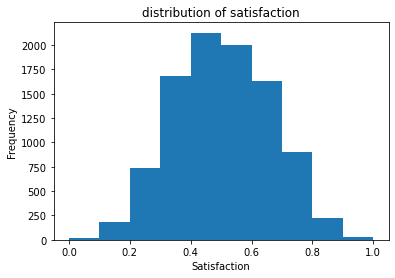

In [17]:
# Distribution plots of continuous variables
# 1) Satisfaction

fig, ax = plt.subplots()
ax.hist(df['satisfaction'])
ax.set_title('distribution of satisfaction')
ax.set_xlabel('Satisfaction')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

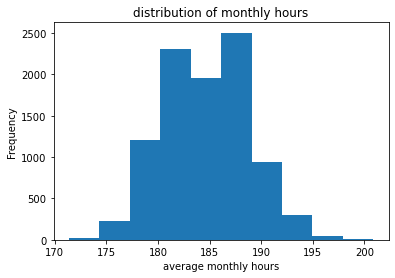

In [18]:
# Average monthly hours
fig, ax = plt.subplots()
ax.hist(df['avg_hrs_month'])
ax.set_title('distribution of monthly hours')
ax.set_xlabel('average monthly hours')
ax.set_ylabel('Frequency')

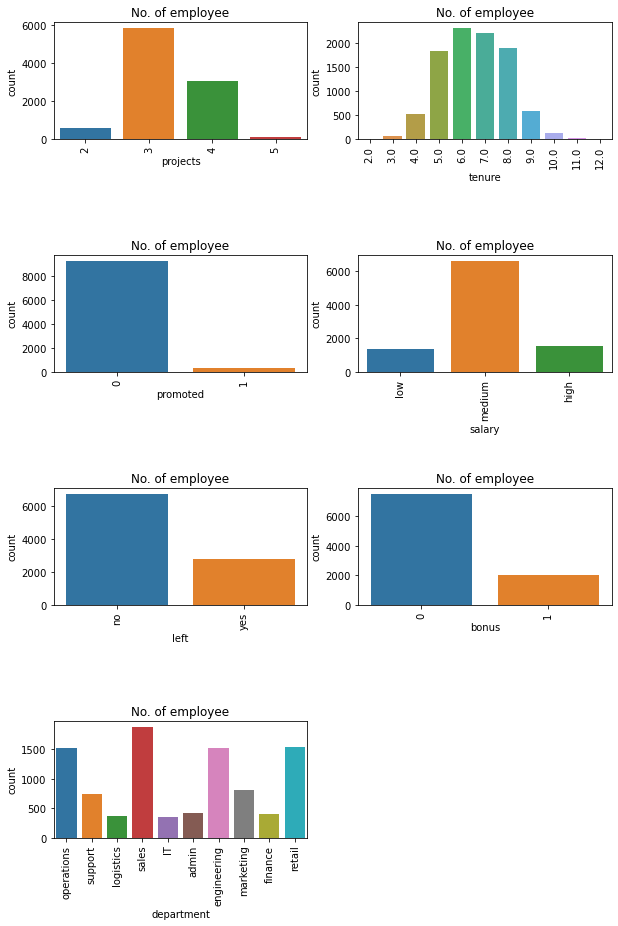

In [19]:
#subplots of discrete variables
features=['projects','tenure','promoted','salary','left','bonus','department']
fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = df)
    plt.xticks(rotation=90)
    plt.title("No. of employee")

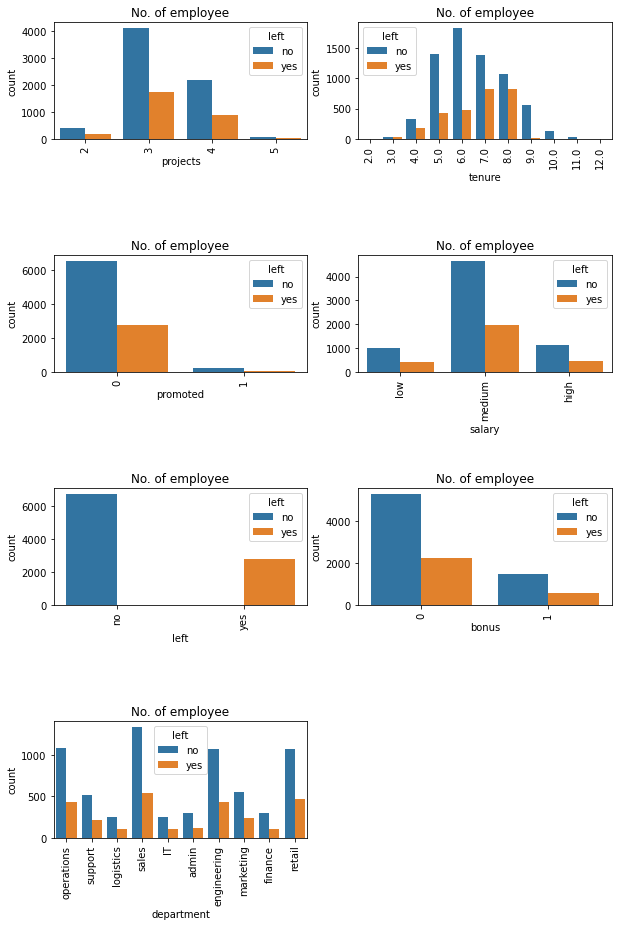

In [19]:
fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = df, hue='left')
    plt.xticks(rotation=90)
    plt.title("No. of employee")

In [98]:
# Significant proportion of employees leave after 7-8 years tenure, while very few employees leave after 9 years in the company

Feature engineering

In [20]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting department and salary labels to numbers
df['salary']=le.fit_transform(df['salary'])
df['department']=le.fit_transform(df['department'])

In [21]:
#setting features and labels
X = df[['promoted', 'review', 'projects','salary','tenure',
       'satisfaction', 'bonus', 'avg_hrs_month','department']]
y = df['left']

In [22]:
#splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 


In [23]:
#creating and fitting random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [24]:
print(classification_report(y_test, clf.predict(X_test)))
print('Random Forest accuracy with all features:', accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

          no       0.88      0.93      0.91      2023
         yes       0.80      0.70      0.75       839

    accuracy                           0.86      2862
   macro avg       0.84      0.82      0.83      2862
weighted avg       0.86      0.86      0.86      2862

Random Forest accuracy with all features: 0.8623340321453529


In [ ]:
# hyperparameter tuning using gridsearchcv---SLOW to run

In [52]:
clf = RandomForestClassifier(random_state=1)

param_grid = {
    'n_estimators':[50,75,100,125],
    'min_samples_split':[2,4,6,8],
    'min_samples_leaf':[1,2,3,4],
    'max_depth':[2,4,6,8]}

grid_obj = GridSearchCV(
    clf,
    return_train_score=True,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5)

grid_fit = grid_obj.fit(X_train,y_train)
clf_opt = grid_fit.best_estimator_

print("="*20)
print("best params:" + str(grid_obj.best_estimator_))
print("best params:" + str(grid_obj.best_params_))
print("best score:",grid_obj.best_score_)
print("="*20)



best params:RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=50, random_state=1)
best params:{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 50}
best score: 0.8709188364843348


In [25]:
# calculating feature importance
feature_importance = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_importance


avg_hrs_month    0.272546
satisfaction     0.269266
review           0.267439
tenure           0.084938
department       0.049414
projects         0.020590
salary           0.018609
bonus            0.012813
promoted         0.004384
dtype: float64

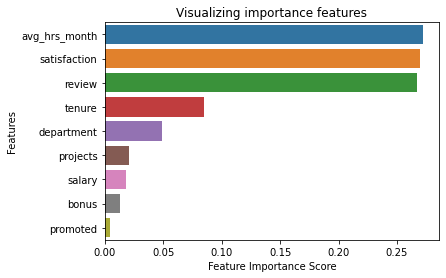

In [26]:
#Plotting feature importance

sns.barplot(x=feature_importance,y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing importance features')
plt.show()



Projects, salary,bonus and promoted are all low importance features

In [27]:
#Try removing promoted,bonus,salary and projects, the least important features

X = df[['review','tenure',
       'satisfaction','avg_hrs_month','department']]
y = df['left']

In [28]:
#fit classifier to new+reduced features
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy with reduced features:',accuracy_score(y_test,y_pred))


Accuracy with reduced features: 0.8616352201257862


Removing the least important features does not significantly improve model performance

In [29]:
# try Gradient boost classifier using all original features
X = df[['promoted', 'review', 'projects','salary','tenure',
       'satisfaction', 'bonus', 'avg_hrs_month','department']]
y = df['left']
X_train,X_test,y_train,y_test = train_test_split(
        X, y, test_size=0.3)
gbrt = GradientBoostingClassifier(random_state=1)
gbrt.fit(X_train,y_train)
print(classification_report(y_test, gbrt.predict(X_test)))
print('Gradient boost accuracy on training set: {:.3f}'.format(gbrt.score(X_train,y_train)))
print('Gradient boost accuracy on test set:{:.3f}'.format(gbrt.score(X_test,y_test)))

              precision    recall  f1-score   support

          no       0.89      0.94      0.91      2052
         yes       0.81      0.71      0.76       810

    accuracy                           0.87      2862
   macro avg       0.85      0.82      0.84      2862
weighted avg       0.87      0.87      0.87      2862

Gradient boost accuracy on training set: 0.874
Gradient boost accuracy on test set:0.872


In [53]:
gbrt = GradientBoostingClassifier(random_state=1)


param_grid = {
    'n_estimators':[50,75,100,125],
    'min_samples_split':[2,4,6,8],
    'min_samples_leaf':[1,2,3,4],
    'max_depth':[2,4,6,8]}

grid_obj = GridSearchCV(
    gbrt,
    return_train_score=True,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5)

grid_fit = grid_obj.fit(X_train,y_train)
grbt_opt = grid_fit.best_estimator_

print("="*20)
print("best params:" + str(grid_obj.best_estimator_))
print("best params:" + str(grid_obj.best_params_))
print("best score:",grid_obj.best_score_)
print("="*20)

best params:GradientBoostingClassifier(max_depth=4, min_samples_split=8, n_estimators=125,
                           random_state=1)
best params:{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 125}
best score: 0.873315279553253


In [69]:
# Logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.717


/Users/ruijin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
#support vector machine
svc = SVC()
svc.fit(X_train, y_train)
print('Support vector machine accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test))))

Support vector machine accuracy: 0.695


In [100]:
# gradient boosting classifier better results than Random Forest Classifier after hyperparameter tuning using GridSearchCV

# Top 3 variables for predicting employee turnover are satisfaction, average monthly hours and review score


### Ploting top three features for leavers and remainers for comparison

In [90]:
leavers = df[df['left']=='yes']

In [38]:
remainers = df[df['left']=='no']

/Users/ruijin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ruijin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Remainers satisfaction')

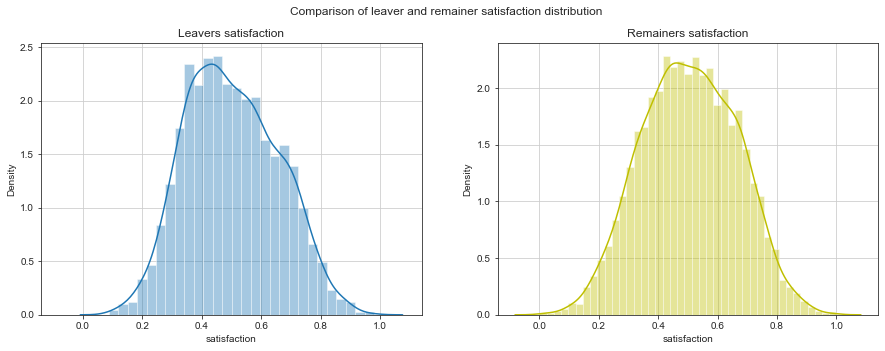

In [92]:
#Visual comparison of satifaction distribution between leavers and remainers


sns.set_style("ticks",{'axes.grid' : True})

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('Comparison of leaver and remainer satisfaction distribution')

sns.distplot(leavers['satisfaction'],ax=axes[0],)
axes[0].set_title('Leavers satisfaction')

sns.distplot(remainers['satisfaction'],ax=axes[1],color='y')
axes[1].set_title('Remainers satisfaction')





In [91]:
# The histgrams show that leavers have slightly lower satisfaction compared to remainers

/Users/ruijin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ruijin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Remainers review score distribution')

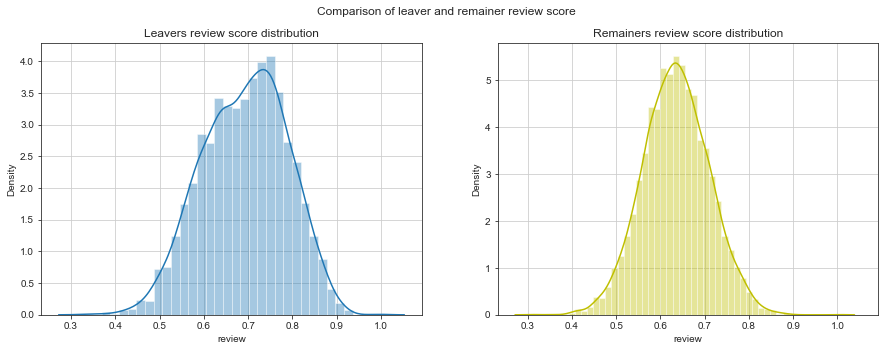

In [65]:
#Visual comparison of review score distribution

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('Comparison of leaver and remainer review score')

sns.distplot(leavers['review'],ax=axes[0])
axes[0].set_title('Leavers review score distribution')

sns.distplot(remainers['review'],ax=axes[1],color='y')
axes[1].set_title('Remainers review score distribution')


In [93]:
# Leavers have higher review scores compared to remainers

/Users/ruijin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ruijin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Remainers average monthly hours distribution')

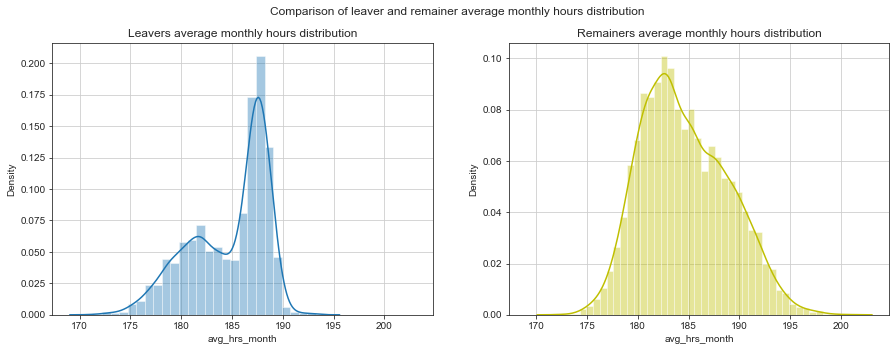

In [63]:
#Visual comparison of average monthly hours between leavers and remainers

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('Comparison of leaver and remainer average monthly hours distribution')

sns.distplot(leavers['avg_hrs_month'],ax=axes[0])
axes[0].set_title('Leavers average monthly hours distribution')

sns.distplot(remainers['avg_hrs_month'],ax=axes[1],color='y')
axes[1].set_title('Remainers average monthly hours distribution')


In [94]:
# The distribution of average monthly hours for leavers is more uneven compared to remainers. 
# Leavers work more than 185 hours per month, while most remainers work between 180-185 hours per month. 

In [95]:
# We can conclude that leavers work longer hours, have lower satisfaction scored and have higher review scores. 